In [11]:
from src.datasets.crack_loader import CrackLoader
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from utils import set_seed
from src.nets.lenet import LeNet5
import seaborn as sns
from src.nets.swag import SWAG
import torch

DATA_DIR = './data/crack'

set_seed(0)

In [32]:
def compute_uncertainties(probs, eps = 1e-12):
    # T: num MC passes
    # B: batch size
    # C: num classes

    T = probs.shape[0]
    probs = np.clip(probs, eps, 1 - eps)

    probs_mean = np.mean(probs, axis=0) # (B, C) 
    
    total_unc = -np.sum(probs_mean * np.log(probs_mean + eps), axis=1) # (B,) 
    ale_unc = np.mean(-np.sum(probs * np.log(probs + eps), axis=2), axis=0) # (B,)
    epi_unc = total_unc - ale_unc

    return total_unc, ale_unc, epi_unc

## Load dataset
We start by constructing a *dataloader* for the dataset of interest. The labels will be:
- $0$: cracked
- $1$: uncracked
We proceed with a quick visualization for the data of interest

In [2]:
dataset = CrackLoader(data_dir=DATA_DIR, normalize=True)
print(f'Train [80%]: {dataset.train_size}x3x120x120')
print(f'Validation [20%]: {dataset.val_size}x3x120x120')

INFO:root:Loading crack dataset


Train [80%]: 11974x3x120x120
Validation [20%]: 2994x3x120x120


/ibex/user/rossom/conda-environments/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


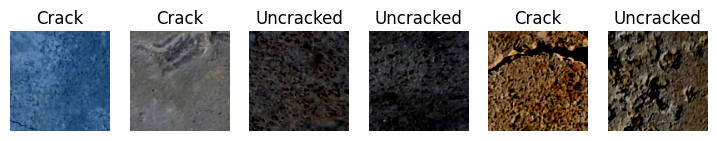

In [5]:
data_iter = iter(dataset.train_loader)
images, labels = next(data_iter)
images = images[:6].cpu()
labels = labels[:6]
    
fig, axs = plt.subplots(1,6,figsize=(9, 3))
for i in range(6):
    img = images[i].permute(1, 2, 0)
    axs[i].imshow(img.squeeze())
    axs[i].set_title('Crack' if labels[i] == 0 else 'Uncracked')
    axs[i].axis('off')
plt.show()

## Import pre-trained model

We first analyze a model trained with naive optimization. The setup is:
- Optimizer: SGD (learning_rate = 1e-3, momentum = 0.09, weight_decay = 5e-4)
- Epochs: 30

array([False,  True,  True, ..., False, False, False])

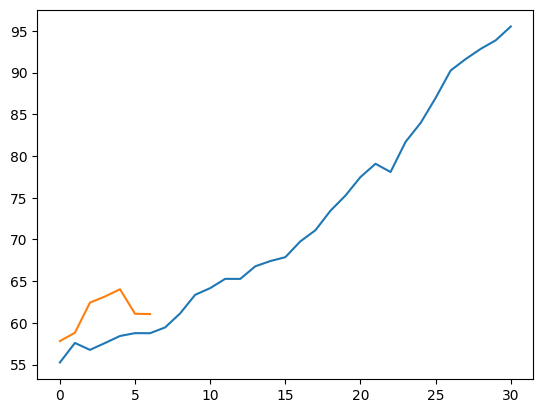

In [50]:
model = torch.load('./experiments/models/lenet5-optim.pt', weights_only=False)
results = np.load('./experiments/results/lenet5-optim.npz')
sns.lineplot(results['train_accuracy_progress'])
sns.lineplot(results['valid_accuracy_progress'])
np.argmax(results['predictions'], axis=-1)
results['true_labels'] == np.argmax(results['predictions'], axis=-1)

In [33]:
model = torch.load('./experiments/models/lenet5-swag.pt', weights_only=False)
results = np.load('./experiments/results/lenet5-swag.npz')
total_unc, ale_unc, epi_unc = compute_uncertainties(results['predictions'])
print("Total uncertainty:\t {:.4f} +- {:.4f}".format(np.mean(total_unc), np.std(total_unc)))
print("Aleatoric uncertainty:\t {:.4f} +- {:.4f}".format(np.mean(ale_unc), np.std(ale_unc)))
print("Epistemic uncertainty:\t {:.4f} +- {:.4f}".format(np.mean(epi_unc), np.std(epi_unc)))

Total uncertainty:	 0.6410 +- 0.0688
Aleatoric uncertainty:	 0.6004 +- 0.0745
Epistemic uncertainty:	 0.0406 +- 0.0183


In [41]:
np.argmax(results['predictions'], axis=-1)

array([[0, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1]])

In [37]:
results['predictions'].shape

(50, 2994, 2)